In [1]:
pip install nibabel matplotlib numpy einops pytorch-ignite

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import os
import zipfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Parameters
SHAPE = (96, 96, 96) # Shape of the 3D images
batch_size = 2

# **Step 1: Load Data**

In [4]:
# Define paths
data_path = '/cluster/projects/vc/data/mic/open/HNTS-MRG'
zip_file = os.path.join(data_path, 'HNTSMRG24_train.zip')

# Path to save extracted files
extracted_path = '/cluster/home/bjorneme/projects/tdt17_mini_project/TDT17_mini_project/Data'

# Create extraction directory if it doesn't exist
os.makedirs(extracted_path, exist_ok=True)

# Unzip the dataset into the specified directory
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # Extract only the 'preRT/' files
    preRT_files = [f for f in zip_ref.namelist() if '/preRT/' in f]
    zip_ref.extractall(path=extracted_path, members=preRT_files)

In [5]:
# Path to the training data
train_dir = os.path.join(extracted_path, 'HNTSMRG24_train')

# List all patient folders
patient_folders = os.listdir(train_dir)
print(f"Total patients extracted: {len(patient_folders)}")

Total patients extracted: 150


# **Step 2: Exploratory Data Analysis (EDA)**

**Prepare EDA**

In [6]:
# Initialize lists to store image information
dimensions = []
voxel_sizes = []
intensities = []
mask_voxel_counts = []

for patient_id in patient_folders[:10]:

    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load MRI and mask
    mri_img = nib.load(mri_path)
    mask_img = nib.load(mask_path)
    
    # Get data arrays
    mri_data = mri_img.get_fdata()
    mask_data = mask_img.get_fdata()
    
    # Collect image dimensions and voxel sizes
    dimensions.append(mri_data.shape)
    voxel_sizes.append(mri_img.header.get_zooms())
    
    # Collect intensity statistics
    intensities.append({
        'mean': np.mean(mri_data),
        'std': np.std(mri_data),
        'min': np.min(mri_data),
        'max': np.max(mri_data),
    })
    
    # Count the number of voxels in each class
    unique, counts = np.unique(mask_data, return_counts=True)
    mask_voxel_counts.append(dict(zip(unique.astype(int), counts)))


**EDA: Image Dimensions**

In [7]:
# Convert dimensions to a NumPy array
dimensions_array = np.array(dimensions)

# Calculate min, max, and mean dimensions
min_dims = dimensions_array.min(axis=0)
max_dims = dimensions_array.max(axis=0)
mean_dims = dimensions_array.mean(axis=0)

# Create a DataFrame for the results
data = {
    "Statistic": ["Minimum", "Maximum", "Mean (rounded)"],
    "Width": [min_dims[0], max_dims[0], mean_dims[0]],
    "Height": [min_dims[1], max_dims[1], mean_dims[1]],
    "Depth": [min_dims[2], max_dims[2], mean_dims[2]]
}

# Display as dataframe
pd.DataFrame(data)

,Statistic,Width,Height,Depth
0,Minimum,512.0,512.0,70.0
1,Maximum,640.0,640.0,110.0
2,Mean (rounded),526.4,526.4,77.2


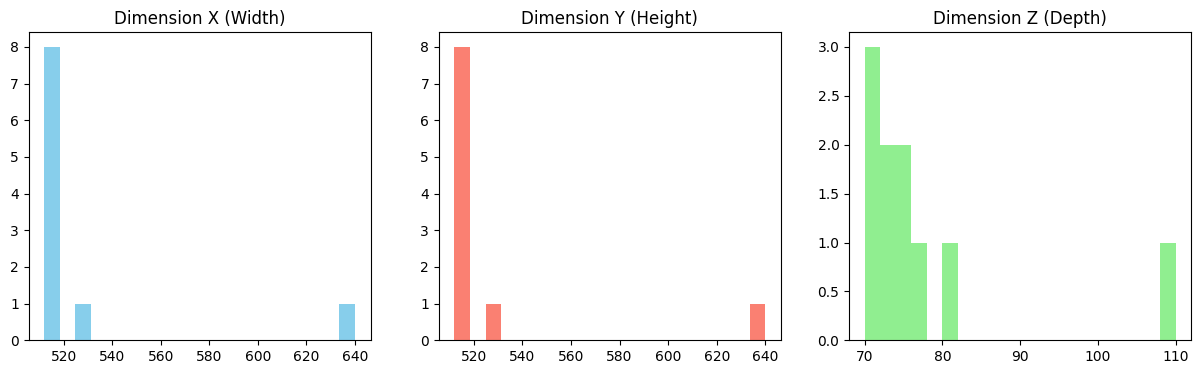

In [8]:
# Plot histograms of dimensions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(dimensions_array[:, 0], bins=20, color='skyblue')
axes[0].set_title('Dimension X (Width)')
axes[1].hist(dimensions_array[:, 1], bins=20, color='salmon')
axes[1].set_title('Dimension Y (Height)')
axes[2].hist(dimensions_array[:, 2], bins=20, color='lightgreen')
axes[2].set_title('Dimension Z (Depth)')
plt.show()

**EDA: Tumor Size and Location**

In [9]:
# Initialize lists
tumor_sizes = []
tumor_locations = []  # e.g., centroid coordinates or predefined regions

for patient_id in patient_folders:
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    mask_img = nib.load(mask_path)
    mask_data = mask_img.get_fdata().astype(int)

    # Calculate tumor size (number of voxels in tumor classes)
    tumor_voxels = mask_data > 0
    size = np.sum(tumor_voxels)
    tumor_sizes.append(size)

    # Calculate tumor centroid
    coords = np.column_stack(np.where(mask_data > 0))
    if coords.size > 0:
        centroid = coords.mean(axis=0)
        tumor_locations.append(centroid)
    else:
        tumor_locations.append([np.nan, np.nan, np.nan])

# Convert to DataFrame
eda_df = pd.DataFrame({
    'Patient_ID': patient_folders,
    'Tumor_Size': tumor_sizes,
    'Centroid_X': [loc[0] for loc in tumor_locations],
    'Centroid_Y': [loc[1] for loc in tumor_locations],
    'Centroid_Z': [loc[2] for loc in tumor_locations],
})

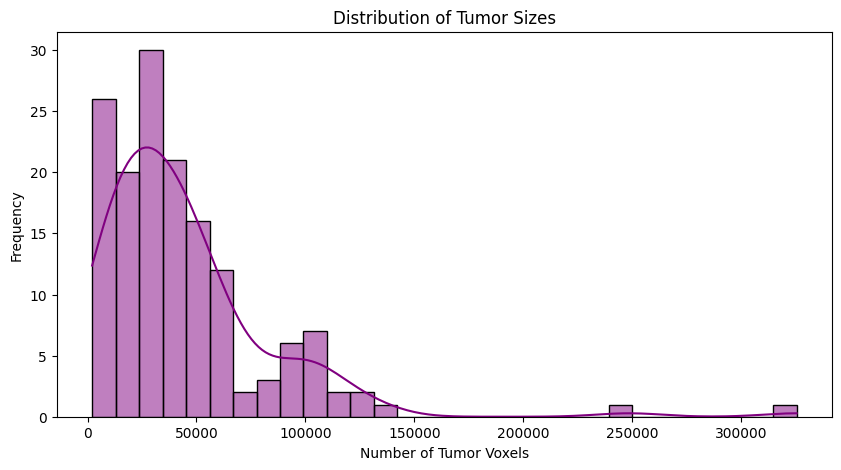

In [10]:
import seaborn as sns

# Plot distribution of tumor sizes
plt.figure(figsize=(10, 5))
sns.histplot(eda_df['Tumor_Size'], bins=30, kde=True, color='purple')
plt.title('Distribution of Tumor Sizes')
plt.xlabel('Number of Tumor Voxels')
plt.ylabel('Frequency')
plt.show()

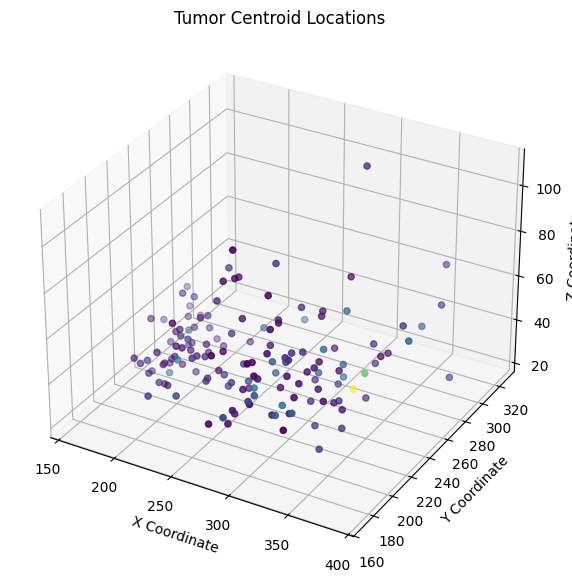

In [11]:
# 3D Scatter plot of tumor centroids (optional, requires mplot3d)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(eda_df['Centroid_X'], eda_df['Centroid_Y'], eda_df['Centroid_Z'], c=eda_df['Tumor_Size'], cmap='viridis')
ax.set_title('Tumor Centroid Locations')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.show()

**EDA: Understand class distribution (Background, GTVp, GTVn)**

In [12]:
# Aggregate mask voxel counts
class_counts = {}
for counts in mask_voxel_counts:
    for k, v in counts.items():
        class_counts[k] = class_counts.get(k, 0) + v

# Calculate total voxels
total_voxels = sum(class_counts.values())

# Calculate percentages
class_percentages = {int(k): (v / total_voxels) * 100 for k, v in class_counts.items()}

print("Class Distribution in Masks (% of total voxels):")
for cls, pct in class_percentages.items():
    print(f"Class {cls}: {pct:.4f}%")

Class Distribution in Masks (% of total voxels):
Class 0: 99.6534%
Class 1: 0.1158%
Class 2: 0.2308%


**Plot samples**

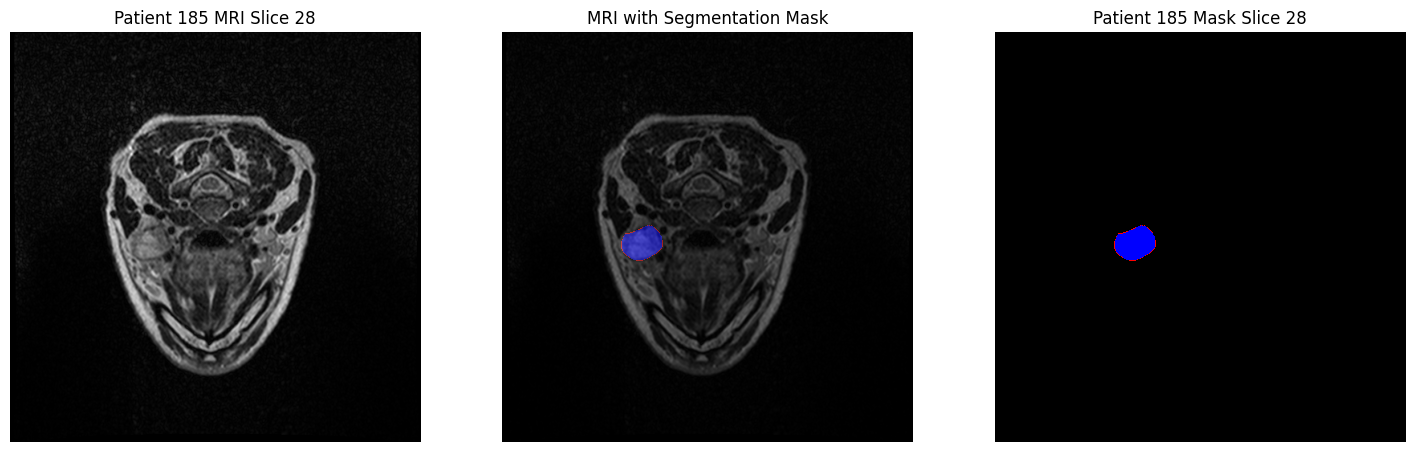

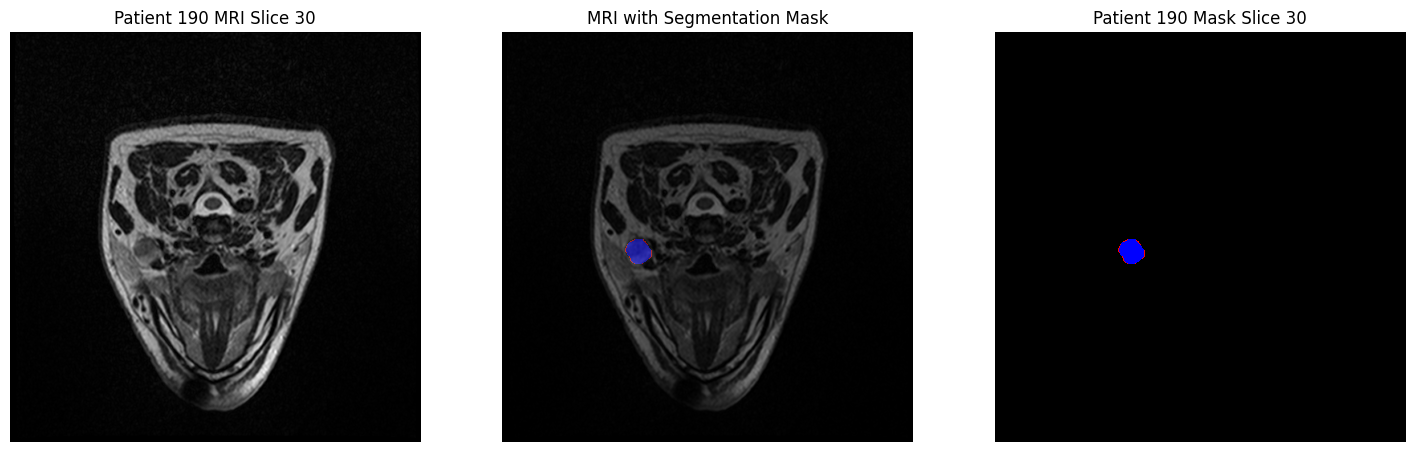

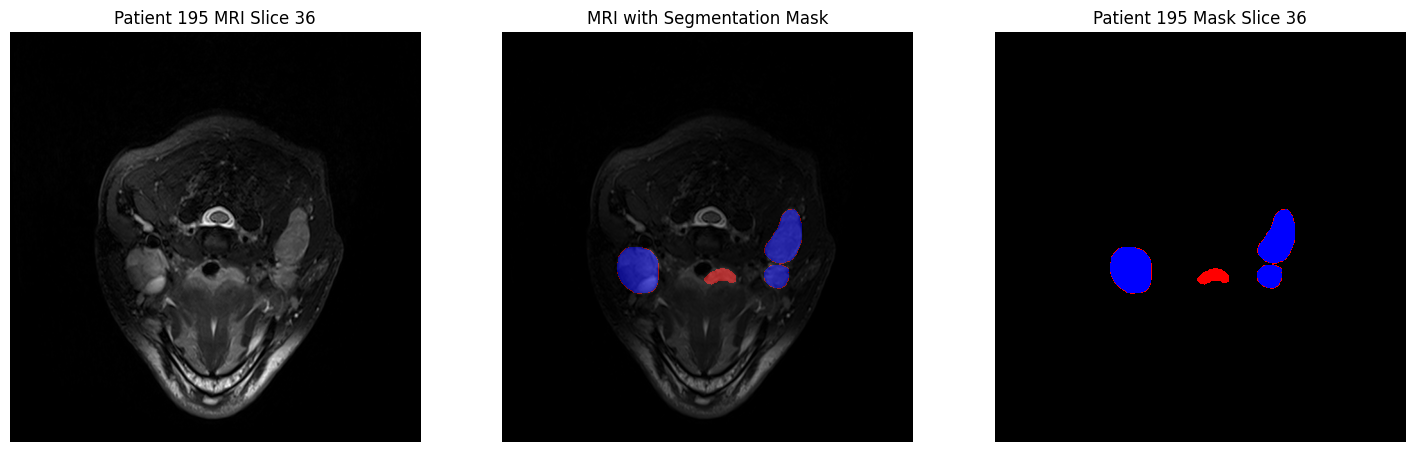

In [13]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import colors

def plot_sample(patient_id, slice_index=None):
    # Define paths
    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load data
    mri_data = nib.load(mri_path).get_fdata()
    mask_data = nib.load(mask_path).get_fdata().astype(int)
    
    # Select the middle slice
    slice_index = mri_data.shape[2] // 2
    mri_slice = mri_data[:, :, slice_index].T
    mask_slice = mask_data[:, :, slice_index].T
    
    # Define colormap for mask
    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. MRI Image
    axes[0].imshow(mri_slice, cmap='gray', origin='lower')
    axes[0].set_title(f'Patient {patient_id} MRI Slice {slice_index}')
    axes[0].axis('off')
    
    # 2. MRI with Mask Overlay
    axes[1].imshow(mri_slice, cmap='gray', origin='lower')
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='lower')
    axes[1].set_title('MRI with Segmentation Mask')
    axes[1].axis('off')
    
    # 3. Mask Only
    im = axes[2].imshow(mask_slice, cmap=cmap, norm=norm, origin='lower')
    axes[2].set_title(f'Patient {patient_id} Mask Slice {slice_index}')
    axes[2].axis('off')

    plt.show()

# Plot samples from a few patients
patient_ids = ['185', '190', '195']
for pid in patient_ids:
    plot_sample(pid)

# **Step 3: Data Preprocessing**

In [14]:
import torch
from monai.data import CacheDataset, DataLoader
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd,
    EnsureTyped, Resized
)
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-23 12:19:39.260534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732360779.360864 1523737 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732360779.398580 1523737 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 12:19:39.651082: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in 

In [15]:
# Create data dictionaries
data_dicts = [
    {
        "image": os.path.join(train_dir, pid, 'preRT', f'{pid}_preRT_T2.nii.gz'),
        "label": os.path.join(train_dir, pid, 'preRT', f'{pid}_preRT_mask.nii.gz'),
    }
    for pid in patient_folders
]

**Split the dataset into training and validation**

In [16]:
# Split data into training and validation sets
train_files = data_dicts[:120]
val_files = data_dicts[120:]

**Transform image**

In [17]:
# Transform the images for training and validation
train_transforms = Compose([
    # Load images and labels
    LoadImaged(keys=["image", "label"]),

    # Ensure channel dimension
    EnsureChannelFirstd(keys=["image", "label"]),

    # Scale image intensity to [0, 1]
    ScaleIntensityd(keys=["image"]),

    # Ensure equal size
    Resized(keys=["image", "label"], spatial_size=SHAPE, mode=("trilinear", "nearest")),

    # Convert to PyTorch tensors
    EnsureTyped(keys=["image", "label"]),
])

val_transforms = Compose([
    # Load images and labels
    LoadImaged(keys=["image", "label"]),

    # Ensure channel dimension
    EnsureChannelFirstd(keys=["image", "label"]),

    # Scale image intensity to [0, 1]
    ScaleIntensityd(keys=["image"]),

    # Ensure equal size
    Resized(keys=["image", "label"], spatial_size=SHAPE, mode=("trilinear", "nearest")),

    # Convert to PyTorch tensors
    EnsureTyped(keys=["image", "label"]),
])

**Create dataset and dataloaders**

In [18]:
# Create datasets
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)

# Create data loaders
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

Loading dataset: 100%|██████████| 30/30 [00:28<00:00,  1.04it/s]



Train Batch 1:


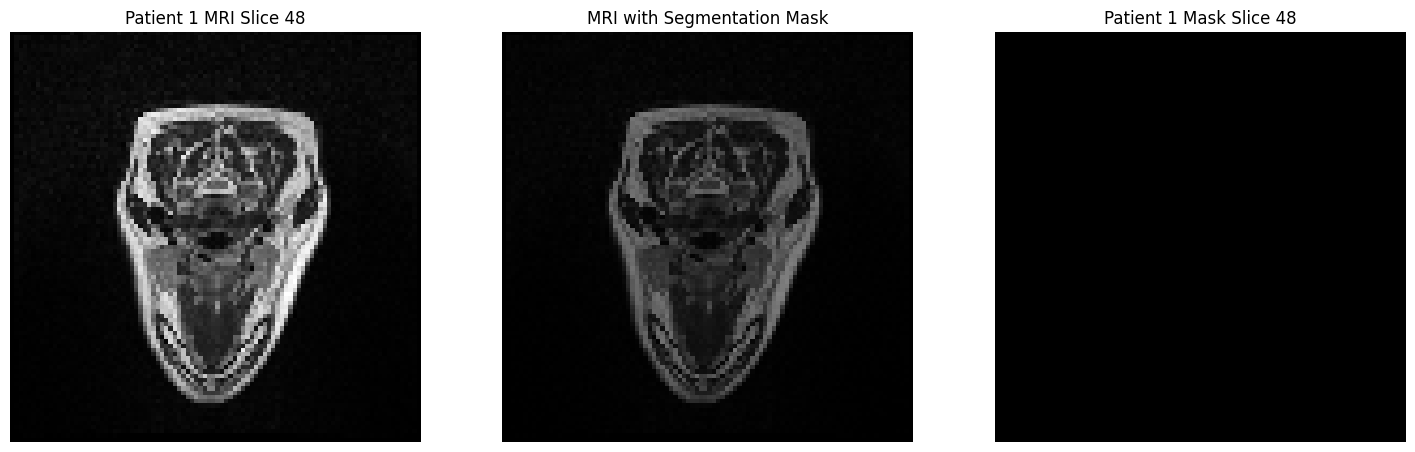

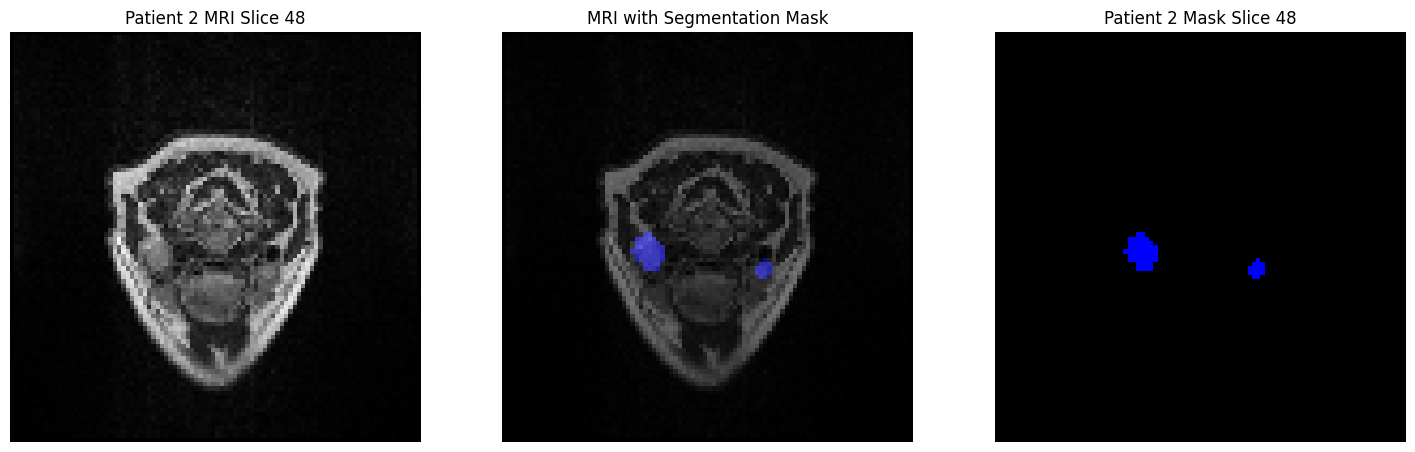


Train Batch 2:


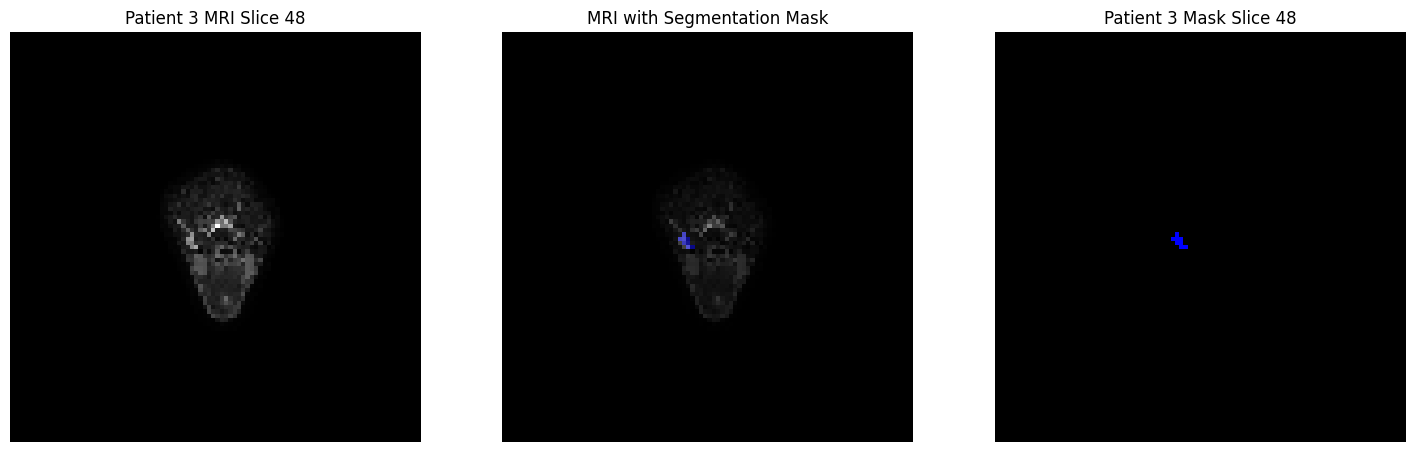

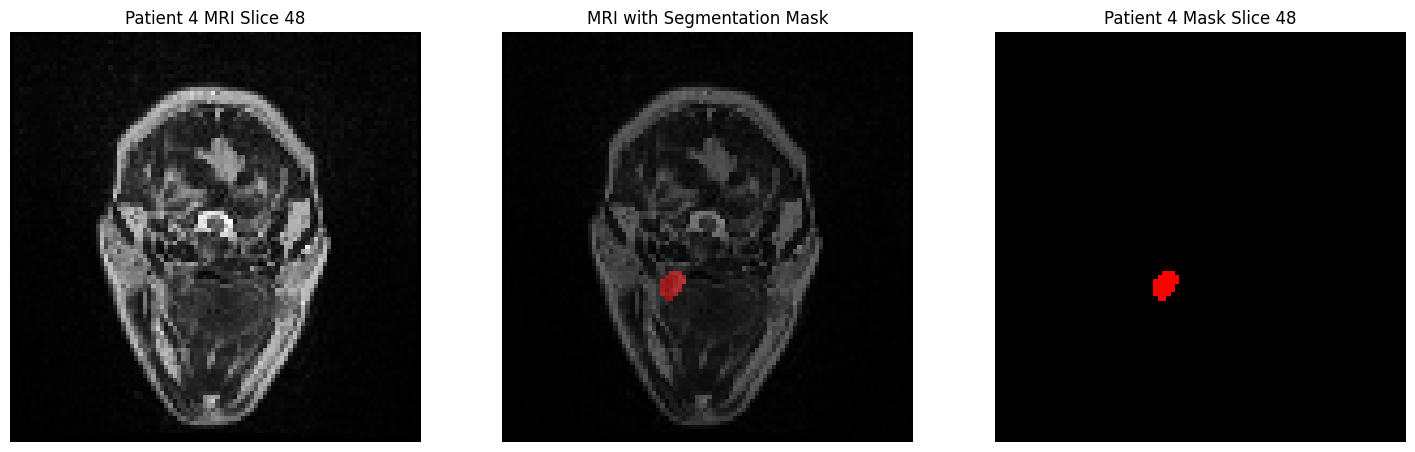


Validation Batch 1:


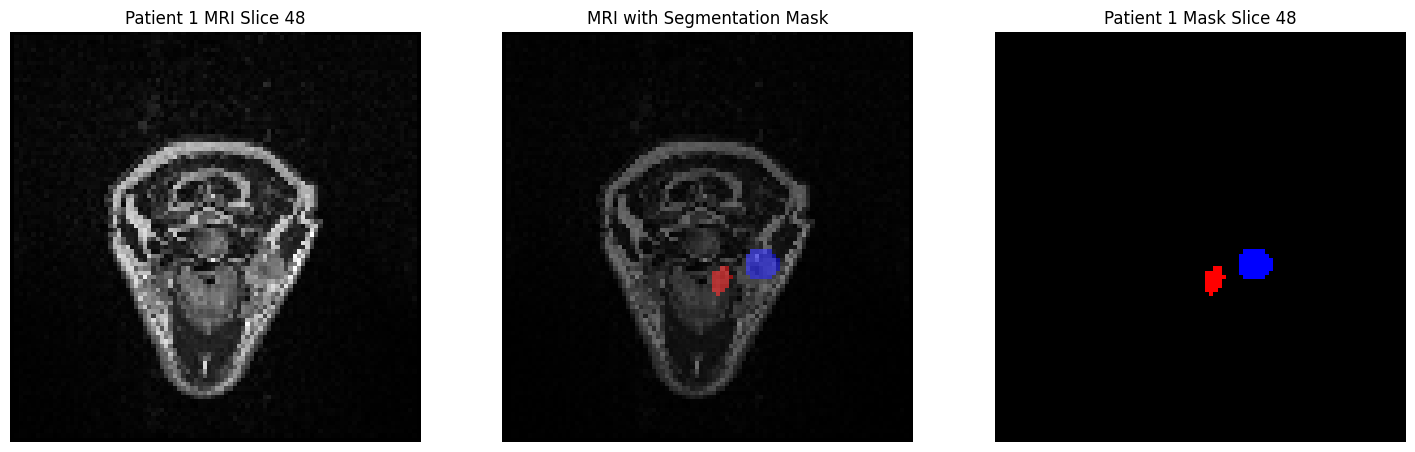

In [19]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import colors
import torch
import numpy as np
from torch.utils.data import DataLoader

# Define your plotting function
def plot_dataloader_sample(image_tensor, label_tensor, patient_id=None, slice_index=None):
    """
    Plots MRI image, MRI with segmentation mask overlay, and mask only from tensors.
    """
    image_np = image_tensor.cpu().numpy()
    label_np = label_tensor.cpu().numpy()

    if image_np.shape[0] == 1:
        image_np = np.squeeze(image_np, axis=0)

    if label_np.ndim == 4 and label_np.shape[0] == 1:
        label_np = np.squeeze(label_np, axis=0)

    if slice_index is None:
        slice_index = image_np.shape[2] // 2

    mri_slice = image_np[:, :, slice_index].T
    mask_slice = label_np[:, :, slice_index].T

    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(mri_slice, cmap='gray', origin='lower')
    title1 = f'Patient {patient_id} MRI Slice {slice_index}' if patient_id else f'MRI Slice {slice_index}'
    axes[0].set_title(title1)
    axes[0].axis('off')

    axes[1].imshow(mri_slice, cmap='gray', origin='lower')
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='lower')
    axes[1].set_title('MRI with Segmentation Mask')
    axes[1].axis('off')

    im = axes[2].imshow(mask_slice, cmap=cmap, norm=norm, origin='lower')
    title3 = f'Patient {patient_id} Mask Slice {slice_index}' if patient_id else f'Mask Slice {slice_index}'
    axes[2].set_title(title3)
    axes[2].axis('off')

    plt.show()

# Visualization function
def visualize_dataloader_samples(dataloader, num_batches=1, samples_per_batch=2, mode='Train'):
    for batch_idx, batch_data in enumerate(dataloader):
        if batch_idx >= num_batches:
            break

        images = batch_data["image"]
        labels = batch_data["label"]

        batch_size = images.shape[0]
        print(f"\n{mode} Batch {batch_idx + 1}:")
        for i in range(min(samples_per_batch, batch_size)):
            image = images[i]
            label = labels[i]
            patient_id = f"{batch_idx * dataloader.batch_size + i + 1}"
            plot_dataloader_sample(image, label, patient_id=patient_id)

# Example usage
# Ensure that 'train_loader' and 'val_loader' are already defined as per your initial setup
visualize_dataloader_samples(train_loader, num_batches=2, samples_per_batch=2, mode='Train')
visualize_dataloader_samples(val_loader, num_batches=1, samples_per_batch=1, mode='Validation')


# **Step 4: Build Model**

Define Model, Loss, Optimizer, and Metrics

In [20]:
# uncomment to download the pre-trained weights
# !wget https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from monai.networks.nets import SwinUNETR

# Define the model
model = SwinUNETR(
    img_size=SHAPE,
    in_channels=1,
    out_channels=3,
    feature_size=48,
    use_checkpoint=True,
).to(device)

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


In [22]:
weight = torch.load("./pretrained_model/model_swinvit.pt")
model.load_from(weights=weight)
print("Using pretrained self-supervied Swin UNETR backbone weights !")

# Freeze all parameters initially
for param in model.parameters():
    param.requires_grad = False

# Enable fine-tuning for the last 10 layers
# Get a list of all parameter names and parameters
all_layers = list(model.named_parameters())
# Get the last 10 layers
last_10_layers = all_layers[-10:]

# Set requires_grad=True for the last 10 layers
for name, param in last_10_layers:
    param.requires_grad = True

# Print parameter states for verification
print("\nParameter states after modification:")
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")


/tmp/ipykernel_1523737/584700282.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight = torch.load("./pretrained_model/model_swinvit.pt")


Using pretrained self-supervied Swin UNETR backbone weights !

Parameter states after modification:
swinViT.patch_embed.proj.weight: requires_grad=False
swinViT.patch_embed.proj.bias: requires_grad=False
swinViT.layers1.0.blocks.0.norm1.weight: requires_grad=False
swinViT.layers1.0.blocks.0.norm1.bias: requires_grad=False
swinViT.layers1.0.blocks.0.attn.relative_position_bias_table: requires_grad=False
swinViT.layers1.0.blocks.0.attn.qkv.weight: requires_grad=False
swinViT.layers1.0.blocks.0.attn.qkv.bias: requires_grad=False
swinViT.layers1.0.blocks.0.attn.proj.weight: requires_grad=False
swinViT.layers1.0.blocks.0.attn.proj.bias: requires_grad=False
swinViT.layers1.0.blocks.0.norm2.weight: requires_grad=False
swinViT.layers1.0.blocks.0.norm2.bias: requires_grad=False
swinViT.layers1.0.blocks.0.mlp.linear1.weight: requires_grad=False
swinViT.layers1.0.blocks.0.mlp.linear1.bias: requires_grad=False
swinViT.layers1.0.blocks.0.mlp.linear2.weight: requires_grad=False
swinViT.layers1.0.blo

In [23]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# **Step 5: Train and Validate Model**

In [24]:
import torch
from monai.metrics import DiceMetric
import torch.nn.functional as F

from torch.optim.lr_scheduler import ReduceLROnPlateau
import monai

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Initialize DiceMetric
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

best_dice_score = -1
best_dice_score_epoch = -1

# Initialize lists to store loss values
train_losses = []
val_losses = []
dice_scores = []

# Training Loop
max_epochs = 30
for epoch in range(max_epochs):
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    for batch_data in train_loader:
        # Get inputs and labels
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = loss_function(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Training Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:

            # Get inputs and labels
            inputs = batch["image"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = loss_function(outputs, labels)

            # Accumulate loss
            val_loss += loss.item()

            # Compute probabilities and predictions
            probabilities = torch.softmax(outputs, dim=1)
            predictions = torch.argmax(probabilities, dim=1, keepdim=True)

            # Update DiceMetric
            dice_metric(predictions, labels)

    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Compute Dice score
    dice_score = dice_metric.aggregate().item()
    dice_metric.reset()
    dice_scores.append(dice_score)

    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Dice Score: {dice_score:.4f}")

    # In the training loop, after validation:
    scheduler.step(avg_val_loss)

    if dice_score > best_dice_score:
            best_dice_score = dice_score
            best_dice_score_epoch = epoch + 1
            torch.save(model.state_dict(), "best_metric_model.pth")
            print("Saved new best metric model")

print(f"Best Metric: {best_dice_score:.4f} at epoch {best_dice_score_epoch}")

Epoch 1/30


/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training Loss: 0.9458
Validation Loss: 0.7233
Validation Dice Score: 0.0000
Saved new best metric model
Epoch 2/30
Training Loss: 0.7042
Validation Loss: 0.6911
Validation Dice Score: 0.0000
Epoch 3/30
Training Loss: 0.6803
Validation Loss: 0.6731
Validation Dice Score: 0.1290
Saved new best metric model
Epoch 4/30
Training Loss: 0.6442
Validation Loss: 0.6208
Validation Dice Score: 0.2404
Saved new best metric model
Epoch 5/30
Training Loss: 0.6038
Validation Loss: 0.6260
Validation Dice Score: 0.1499
Epoch 6/30
Training Loss: 0.5736
Validation Loss: 0.5687
Validation Dice Score: 0.2704
Saved new best metric model
Epoch 7/30
Training Loss: 0.5322
Validation Loss: 0.5480
Validation Dice Score: 0.2389
Epoch 8/30
Training Loss: 0.4925
Validation Loss: 0.5006
Validation Dice Score: 0.3424
Saved new best metric model
Epoch 9/30
Training Loss: 0.4655
Validation Loss: 0.4928
Validation Dice Score: 0.3503
Saved new best metric model
Epoch 10/30
Training Loss: 0.4439
Validation Loss: 0.4845
Va

# **Step 6: Evaluate Model**

In [25]:
import os
import torch
import nibabel as nib
from monai.metrics import DiceMetric
import numpy as np

# Define directories
save_dir = 'predictions_for_3D_Slicer'
os.makedirs(save_dir, exist_ok=True)

# Load the best model
model.load_state_dict(torch.load("best_metric_model.pth"))
model.eval()

# Initialize DICE metric
dice_metric = DiceMetric(include_background=True, reduction="mean")
final_dice_scores = []

# Counter to limit number of saved samples
save_limit = 2  # Number of samples to save
saved_samples = 0

with torch.no_grad():
    for val_data in val_loader:
        val_inputs = val_data["image"].to(device)
        val_labels = val_data["label"].to(device)
        
        # Forward pass
        val_outputs = model(val_inputs)
        
        # Compute DICE
        dice_metric(y_pred=val_outputs, y=val_labels)
        
        # Save predictions for first 'save_limit' samples
        if saved_samples < save_limit:
            for i in range(val_inputs.size(0)):
                if saved_samples >= save_limit:
                    break
                
                # Extract patient ID or create a unique identifier
                # Adjust based on your DataLoader's data structure
                patient_id = f'sample_{saved_samples+1}'
                
                # Get prediction and ground truth
                pred = torch.argmax(val_outputs[i], dim=0).cpu().numpy()
                label = val_labels[i].cpu().numpy()
                
                # Get original image affine if available
                # Assuming 'image_meta_dict' contains affine info
                # Modify if your DataLoader provides it differently
                image_meta = val_data.get("image_meta_dict", None)
                if image_meta:
                    affine = image_meta[i]['affine']
                else:
                    affine = np.eye(4)  # Default affine
                
                # Create NIfTI images
                pred_nifti = nib.Nifti1Image(pred.astype(np.int16), affine)
                label_nifti = nib.Nifti1Image(label.astype(np.int16), affine)
                
                # Save predicted mask
                pred_path = os.path.join(save_dir, f"{patient_id}_pred_mask.nii.gz")
                nib.save(pred_nifti, pred_path)
                
                # Optionally, save ground truth mask for comparison
                gt_path = os.path.join(save_dir, f"{patient_id}_gt_mask.nii.gz")
                nib.save(label_nifti, gt_path)
                
                print(f"Saved prediction for {patient_id}")
                saved_samples += 1
        
        # Early exit if enough samples are saved
        if saved_samples >= save_limit:
            break

# Compute the final DICE score
final_dice_score = dice_metric.aggregate().item()
dice_metric.reset()
print(f"Final DICE score: {final_dice_score:.4f}")

/tmp/ipykernel_1523737/2641942029.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_metric_model.pth"))


Saved prediction for sample_1
Saved prediction for sample_2
Final DICE score: 0.3339


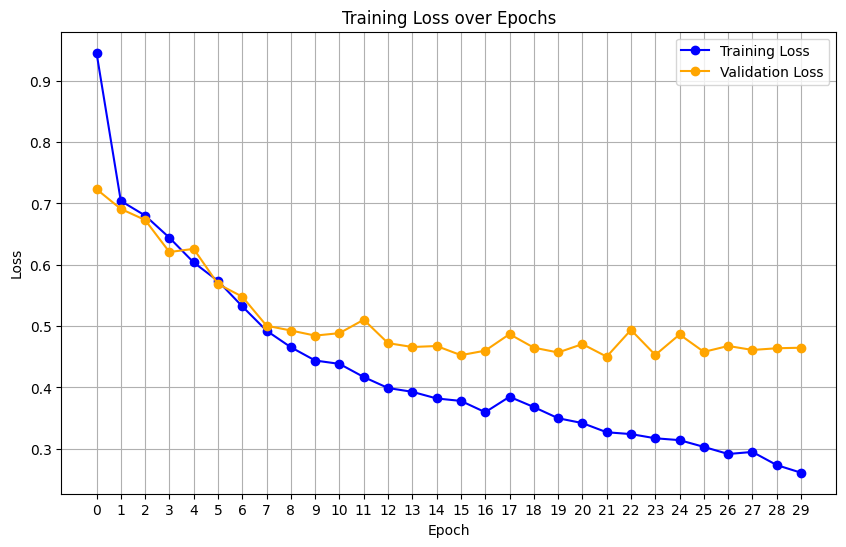

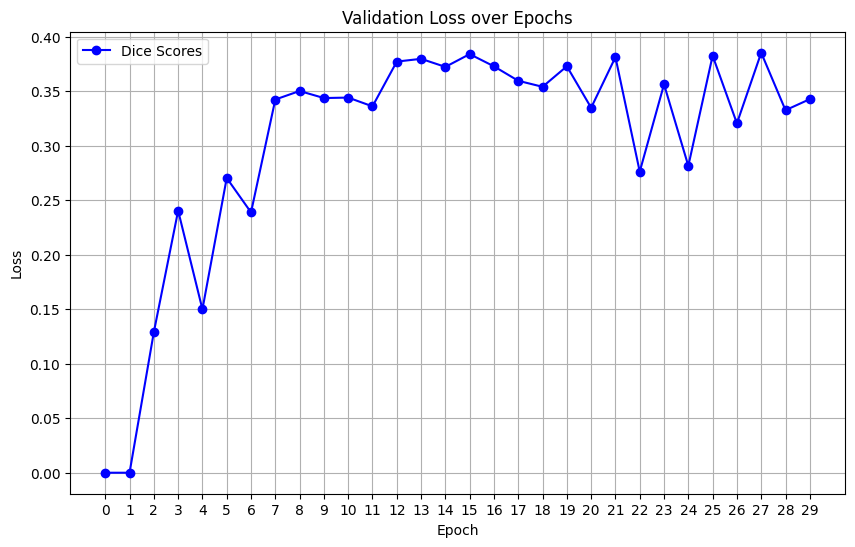

In [26]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(train_losses)), train_losses, label='Training Loss', marker='o', color='blue')
plt.plot(range(0, len(val_losses)), val_losses, label='Validation Loss', marker='o', color='orange')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(0, len(val_losses)))
plt.legend()
plt.grid(True)
plt.show()

# Plot Dice Score
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(dice_scores)), dice_scores, label='Dice Scores', marker='o', color='blue')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(0, len(dice_scores)))
plt.legend()
plt.grid(True)
plt.show()

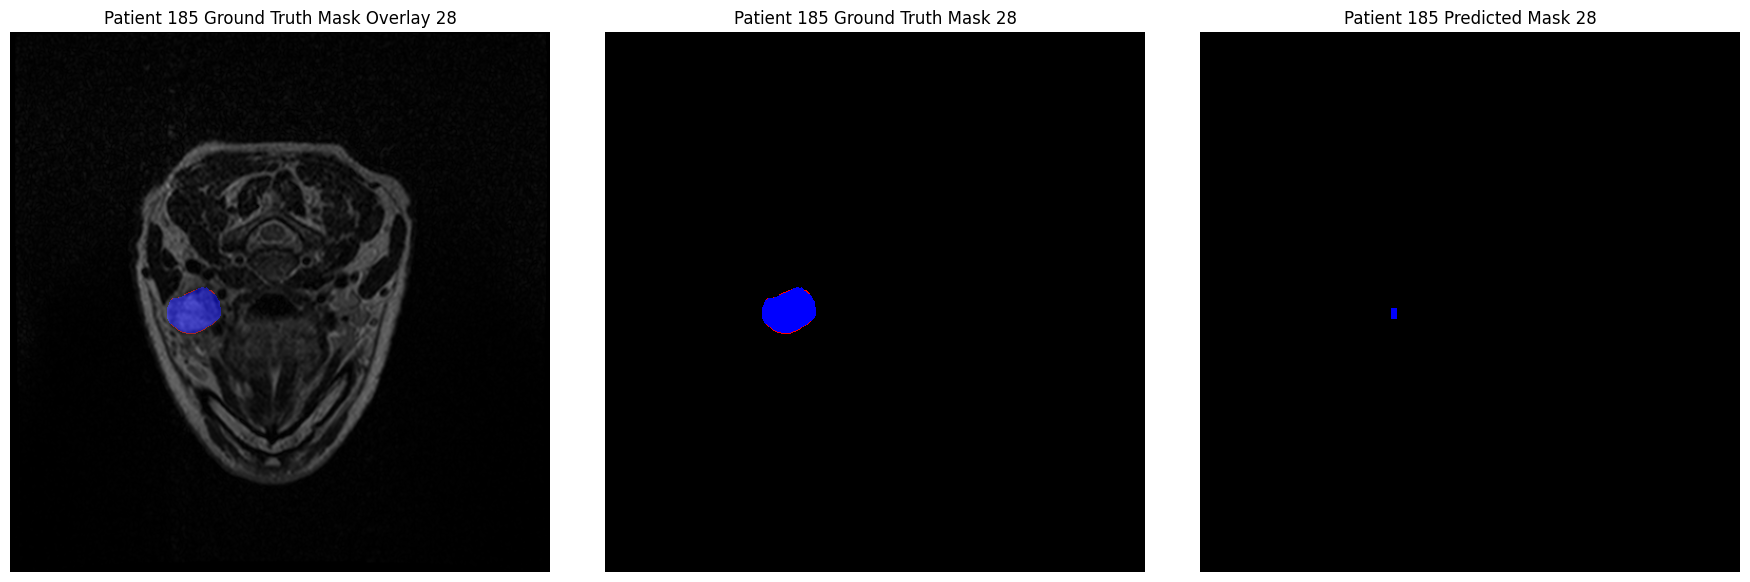

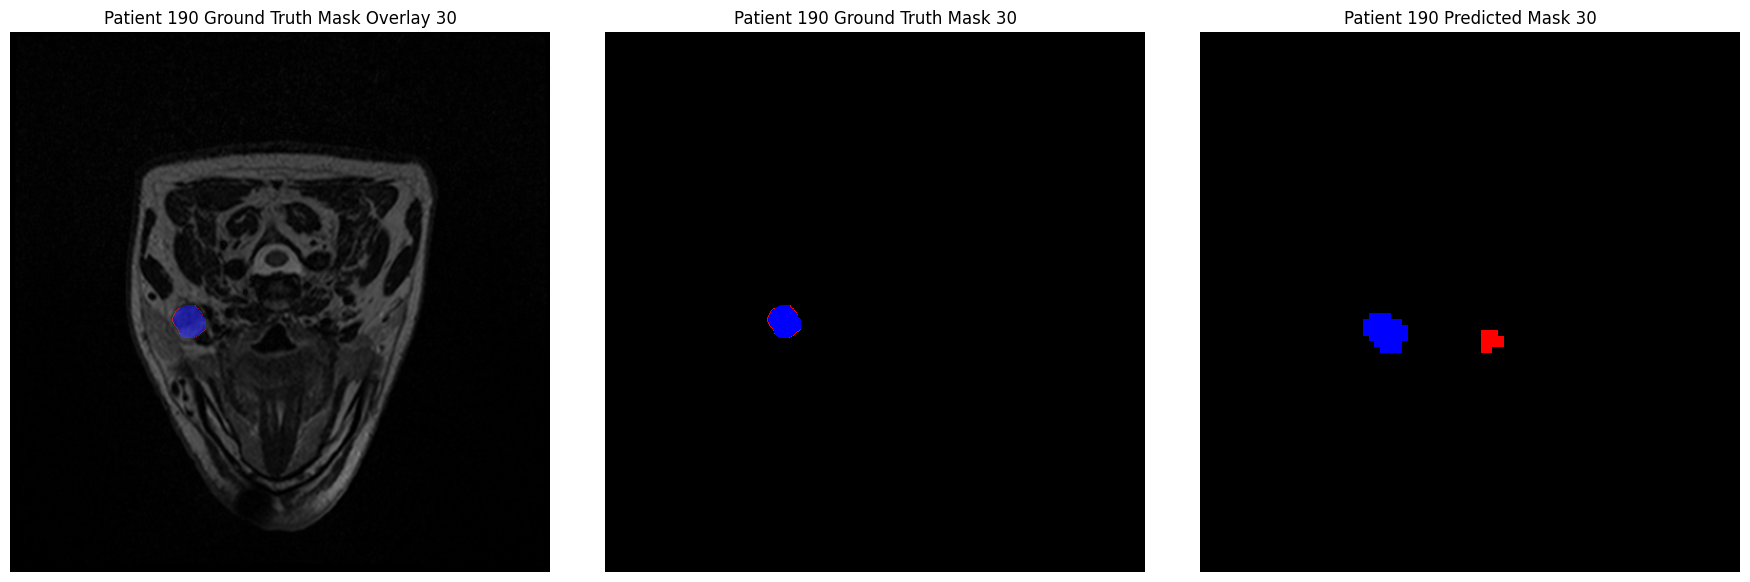

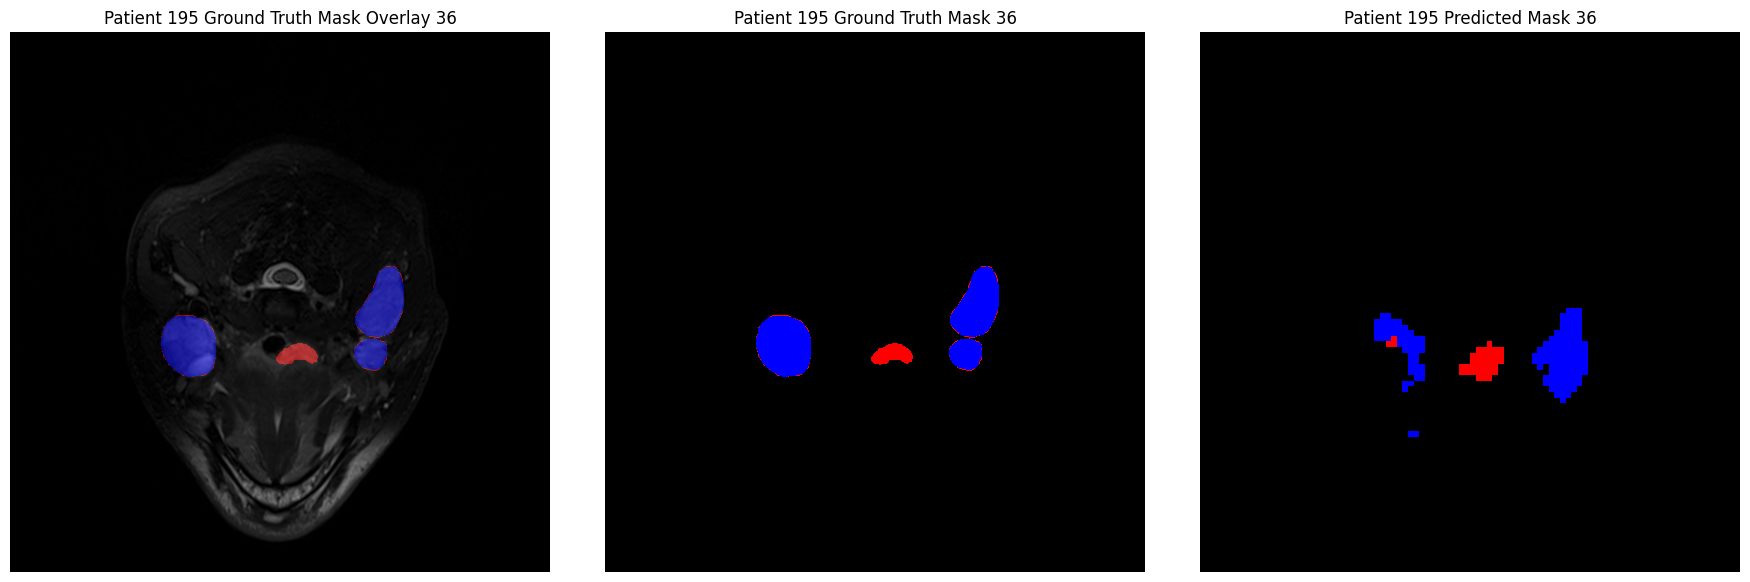

In [27]:
import torch
import matplotlib.pyplot as plt
import nibabel as nib
import os
from matplotlib import colors

def plot_prediction(model, patient_id, slice_index=None, device='cpu'):
    # Define paths
    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load data
    mri_data = nib.load(mri_path).get_fdata()
    mask_data = nib.load(mask_path).get_fdata().astype(int)
    
    # Select middle slice if not specified
    slice_index = slice_index or mri_data.shape[2] // 2
    mri_slice = mri_data[:, :, slice_index].T
    mask_slice = mask_data[:, :, slice_index].T
    
    # Preprocess and predict
    model.eval()
    with torch.no_grad():
        processed = val_transforms({"image": mri_path, "label": mask_path})
        input_tensor = processed["image"].unsqueeze(0).to(device)
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)
        predicted = torch.argmax(probabilities, dim=1).squeeze(0).cpu().numpy()
        predicted_slice = predicted[:, :, slice_index].T
    
    # Define colormap for mask
    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Ground Truth Mask Overlay
    axes[0].imshow(mri_slice, cmap='gray', origin='lower')
    axes[0].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='lower')
    axes[0].set_title(f'Patient {patient_id} Ground Truth Mask Overlay {slice_index}')
    axes[0].axis('off')

    # 2. Ground Truth Mask
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, origin='lower')
    axes[1].set_title(f'Patient {patient_id} Ground Truth Mask {slice_index}')
    axes[1].axis('off')
    
    # 3. Predicted Mask
    axes[2].imshow(predicted_slice, cmap=cmap, norm=norm, origin='lower')
    axes[2].set_title(f'Patient {patient_id} Predicted Mask {slice_index}')
    axes[2].axis('off')
    
    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Ensure the model is on the correct device
model.to(device)

# Plot samples from a few patients
patient_ids = ['185', '190', '195']
for pid in patient_ids:
    plot_prediction(model, patient_id=pid, device=device)


# **Step 7: Sustainability Considerations**

In [28]:
# TODO